In [1]:
import os
import sys
import time
import pickle
import numpy as np
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt

from ast import literal_eval
from scipy.integrate import odeint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error, mean_forecast_error

# To have the Matplotlib plots centered in the notebook
from IPython.core.display import HTML
HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)

# To ignore UserWarnings
import warnings
warnings.filterwarnings('ignore')

# Import local function
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))

from narmax.utils import display_nx_model

from networks.utils import barabasi_sol, barabasi_diff

In [2]:
# Custom function for identification
custom_library = ps.CustomLibrary(library_functions=[lambda x, y : x / y], 
                                  function_names=[lambda x, y : x + '/' + y])

In [3]:
# Get Averaged Model
file = '100_Barabási–Albert_None_(10000,2).dat'
folder_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
file_path = os.path.join(folder_path, file)

with open(file_path, "rb") as input_file:
    data = pickle.load(input_file)

# Get Model characteristics from filename
net_args = file.split('_')
gen_args = literal_eval(net_args[-1].replace('.dat', ''))

# Load Simulated Data
m = gen_args[1]
n = gen_args[0]
t = np.arange(1, n - m + 1)

avg_degrees_hist = data['avg_degree']
k = avg_degrees_hist[:,0]

# Split Data into Train-Test
k_train, k_test, t_train, t_test = train_test_split(k, t, test_size=0.6, shuffle=False)

In [4]:
# Define analytical solutions for the model
k_ant = barabasi_sol(m, 1, t)
k_dif = odeint(barabasi_diff, 2, t).flatten() # Degree evolution from differential equations

In [5]:
# Define SINDy Model
sindy_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=custom_library + ps.PolynomialLibrary(degree=2),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't']
)

# Time added for the time variance in the model
x_train = np.stack((k_train, t_train), axis=-1)
x_test = np.stack((k_test, t_test), axis=-1)

# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t=t_test)[:,0]

k' = 0.470 k/t
t' = 1.000 1


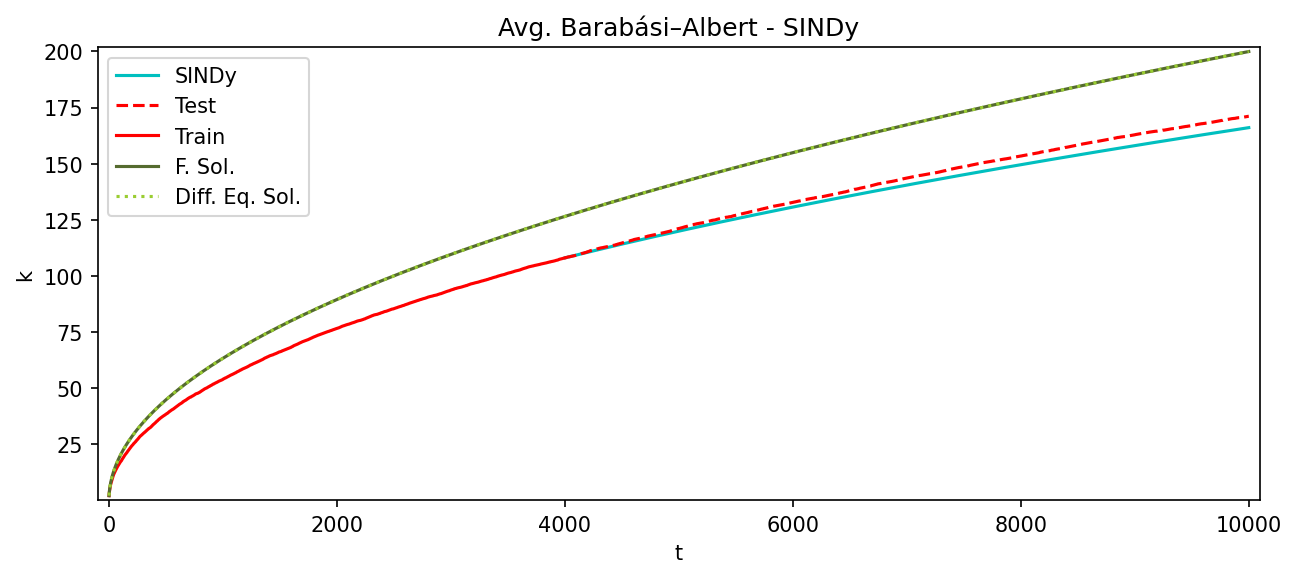

In [6]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Avg. Barabási–Albert - SINDy')
plt.plot(t_test, sindy_sim, "c", label="SINDy")
plt.plot(t_test, k_test, "r--", label="Test")
plt.plot(t_train, k_train, "r", label="Train")
plt.plot(t, k_ant, color='darkolivegreen', label="F. Sol.")
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label="Diff. Eq. Sol.")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [7]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

# Conformal Mapping of Time, to adjust into Polynomial Basis
x_train = 1/t_train
x_test = 1/t_test

# Train model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train.reshape(-1, 1), y=k_train.reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'y')
# Simulate model for the state X
sim_y = nx_model.predict(X=x_test.reshape(-1, 1), y=k_test[0].reshape(-1, 1))

# Stack results for models and predictions
narmax_model = np.array([coeffs_y])
narmax_sim = sim_y

y(k) = 1.000E+00 y(k-1) + 5.106E-01 x1(k-1)y(k-1) + -3.087E-01 x1(k-1)


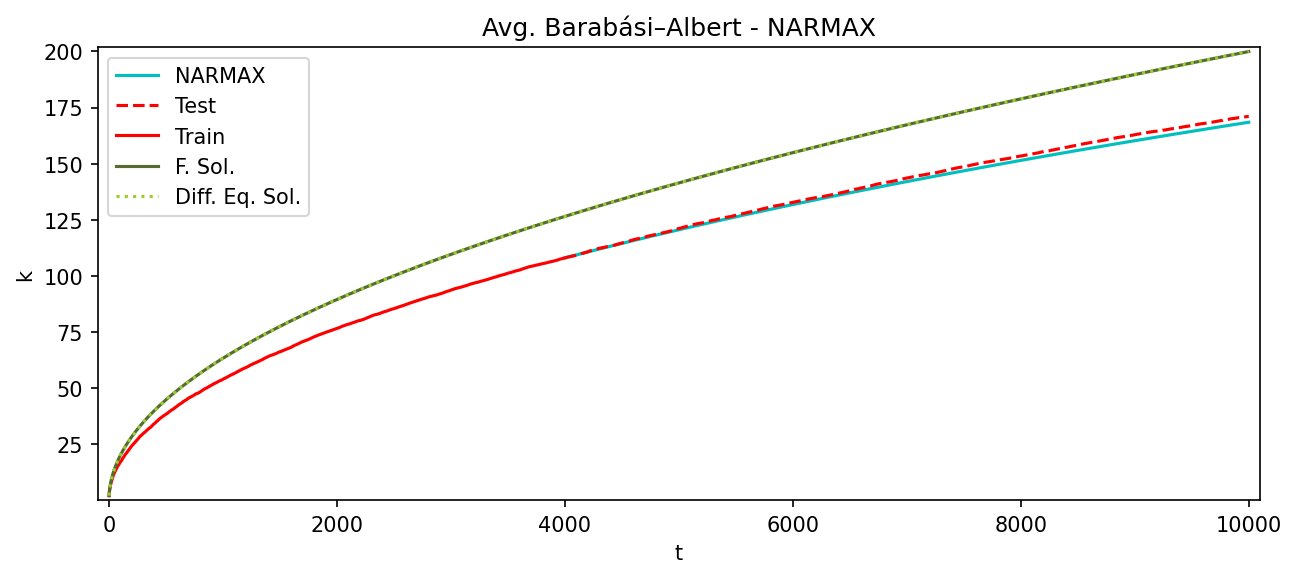

In [8]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Avg. Barabási–Albert - NARMAX')
plt.plot(t_test, narmax_sim, "c", label="NARMAX")
plt.plot(t_test, k_test, "r--", label="Test")
plt.plot(t_train, k_train, "r", label="Train")
plt.plot(t, k_ant, color='darkolivegreen', label="F. Sol.")
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label="Diff. Eq. Sol.")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [9]:
## Metrics
metrics = {}
# 0. L0 Norm
sindy_l0 = np.linalg.norm(sindy_model.coefficients(), ord=0, axis=1)[:1]
narmax_l0 = np.linalg.norm(narmax_model, ord=0, axis=1)
metrics['L0 Norm'] = {'SINDy': sindy_l0, 'NARMAX': narmax_l0}

# 1. Sparsity (L0) Difference
expected_sparsity = np.array([1])
sindy_l0_diff = np.abs(expected_sparsity - sindy_l0)
narmax_l0_diff = np.abs(expected_sparsity - narmax_l0)
metrics['L0 Norm Diff.'] = {'SINDy': sindy_l0_diff, 'NARMAX': narmax_l0_diff}

# 2. Complexity (Sum of L0)
sindy_complexity = sindy_model.complexity
narmax_complexity = np.sum(narmax_l0)
metrics['Complexity'] = {'SINDy': sindy_complexity, 'NARMAX': narmax_complexity}

# 5. Forecast Error
sindy_forecast = mean_forecast_error(k_test, sindy_sim)
narmax_forecast = mean_forecast_error(k_test, narmax_sim)
metrics['Forecast Error'] = {'SINDy': sindy_forecast, 'NARMAX': narmax_forecast}

# 3. Mean Squared Error (MSE)
sindy_mse = mean_squared_error(k_test, sindy_sim)
narmax_mse = mean_squared_error(k_test, narmax_sim)
metrics['MSE'] = {'SINDy': sindy_mse, 'NARMAX': narmax_mse}

# 6. Root Relative Squared Error (RRSE)
sindy_rrse = root_relative_squared_error(k_test, sindy_sim)
narmax_rrse = root_relative_squared_error(k_test, narmax_sim)
metrics['RRSE'] = {'SINDy': sindy_rrse, 'NARMAX': narmax_rrse}

# 4. R2 Score
sindy_r2 = r2_score(k_test, sindy_sim)
narmax_r2 = r2_score(k_test, narmax_sim)
metrics['R2 Score'] = {'SINDy': sindy_r2, 'NARMAX': narmax_r2}

# 5. Training Time
metrics['Time'] = {'SINDy': sindy_time, 'NARMAX': narmax_time}

# Save in a DataFrame and print
metrics_df = pd.DataFrame(metrics)
metrics_df

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[1.0],[0.0],2.0,2.927436,11.030300,0.196959,0.966583,0.033648
NARMAX,[3.0],[2.0],3.0,1.486561,2.981443,112.094064,0.990968,0.020744


In [10]:
# Get Single Case Model
file = '1_Barabási–Albert_None_(10000,2).dat'
folder_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
file_path = os.path.join(folder_path, file)

with open(file_path, "rb") as input_file:
    data = pickle.load(input_file)

# Get Model characteristics from filename
net_args = file.split('_')
gen_args = literal_eval(net_args[-1].replace('.dat', ''))

# Load Simulated Data
m = gen_args[1]
n = gen_args[0]
t = np.arange(1, n - m + 1)

avg_degrees_hist = data['avg_degree']
k = avg_degrees_hist[:,0]

# Split Data into Train-Test
k_train, k_test, t_train, t_test = train_test_split(k, t, test_size=0.6, shuffle=False)

In [11]:
# Define SINDy Model
sindy_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=custom_library + ps.PolynomialLibrary(degree=2),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't']
)

# Time added for the time variance in the model
x_train = np.stack((k_train, t_train), axis=-1)
x_test = np.stack((k_test, t_test), axis=-1)

# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t=t_test)[:,0]

k' = 0.508 k/t
t' = 1.000 1


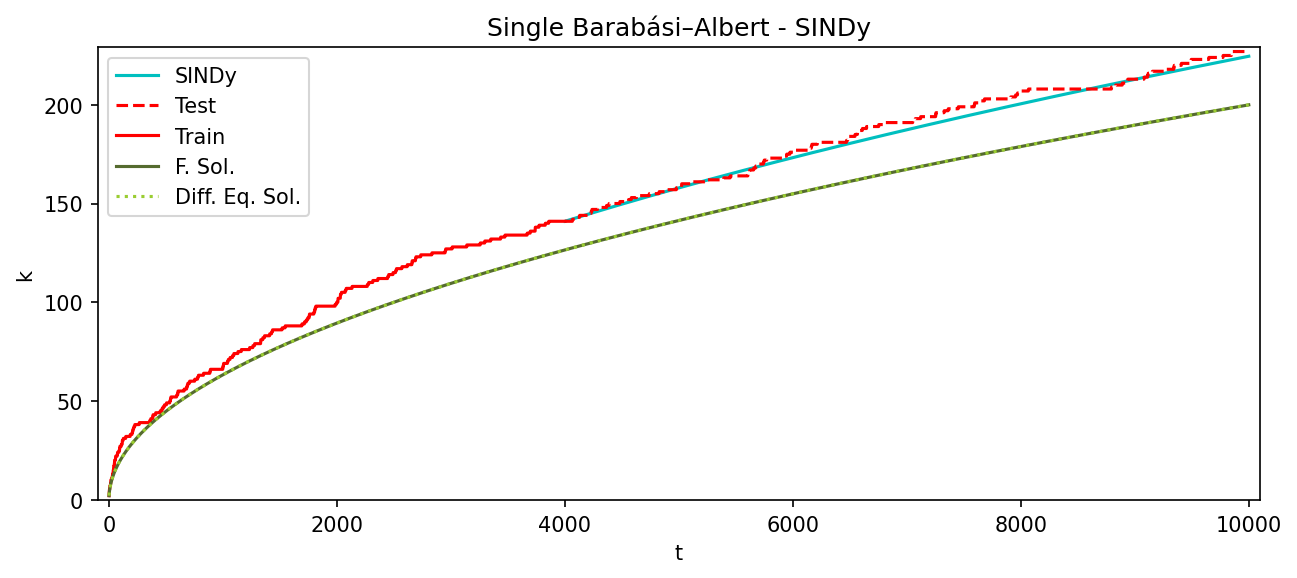

In [12]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Single Barabási–Albert - SINDy')
plt.plot(t_test, sindy_sim, "c", label="SINDy")
plt.plot(t_test, k_test, "r--", label="Test")
plt.plot(t_train, k_train, "r", label="Train")
plt.plot(t, k_ant, color='darkolivegreen', label="F. Sol.")
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label="Diff. Eq. Sol.")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [13]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

# Conformal Mapping of Time, to adjust into Polynomial Basis
x_train = 1/t_train
x_test = 1/t_test

# Train model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train.reshape(-1, 1), y=k_train.reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'y')
# Simulate model for the state X
sim_y = nx_model.predict(X=x_test.reshape(-1, 1), y=k_test[0].reshape(-1, 1))

# Stack results for models and predictions
narmax_model = np.array([coeffs_y])
narmax_sim = sim_y

y(k) = 1.000E+00 y(k-1) + 4.917E-01 x1(k-1)y(k-1)


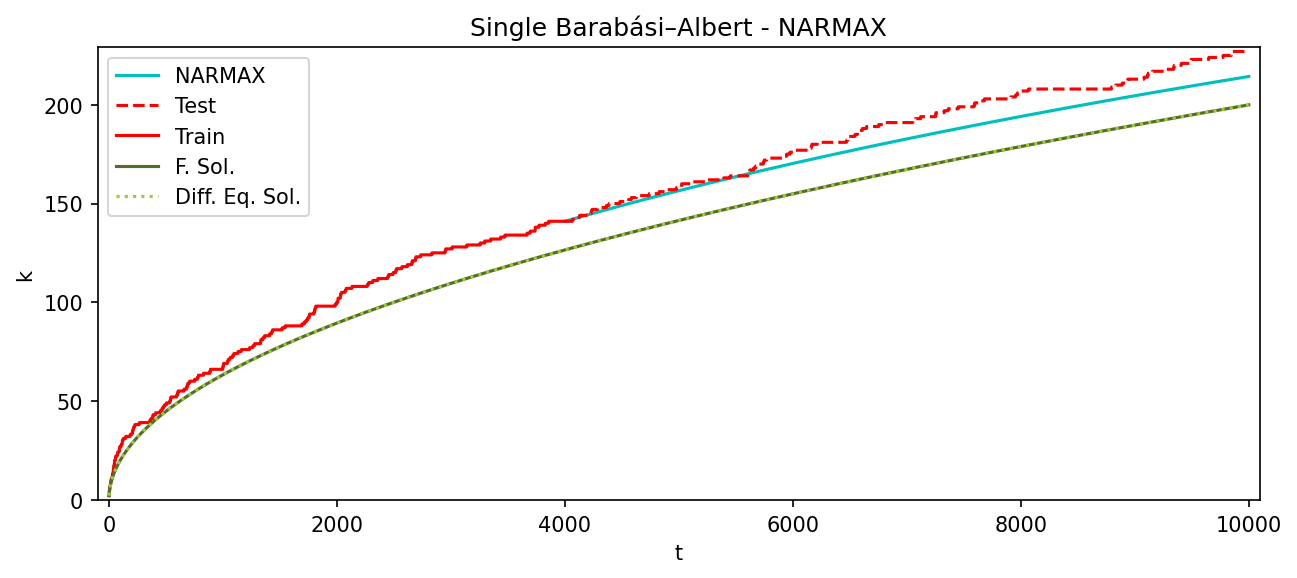

In [14]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Single Barabási–Albert - NARMAX')
plt.plot(t_test, narmax_sim, "c", label="NARMAX")
plt.plot(t_test, k_test, "r--", label="Test")
plt.plot(t_train, k_train, "r", label="Train")
plt.plot(t, k_ant, color='darkolivegreen', label="F. Sol.")
plt.plot(t, k_dif, color='yellowgreen', linestyle='dotted', label="Diff. Eq. Sol.")
plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [15]:
## Metrics
metrics = {}
# 0. L0 Norm
sindy_l0 = np.linalg.norm(sindy_model.coefficients(), ord=0, axis=1)[:1]
narmax_l0 = np.linalg.norm(narmax_model, ord=0, axis=1)
metrics['L0 Norm'] = {'SINDy': sindy_l0, 'NARMAX': narmax_l0}

# 1. Sparsity (L0) Difference
expected_sparsity = np.array([1])
sindy_l0_diff = np.abs(expected_sparsity - sindy_l0)
narmax_l0_diff = np.abs(expected_sparsity - narmax_l0)
metrics['L0 Norm Diff.'] = {'SINDy': sindy_l0_diff, 'NARMAX': narmax_l0_diff}

# 2. Complexity (Sum of L0)
sindy_complexity = sindy_model.complexity
narmax_complexity = np.sum(narmax_l0)
metrics['Complexity'] = {'SINDy': sindy_complexity, 'NARMAX': narmax_complexity}

# 5. Forecast Error
sindy_forecast = mean_forecast_error(k_test, sindy_sim)
narmax_forecast = mean_forecast_error(k_test, narmax_sim)
metrics['Forecast Error'] = {'SINDy': sindy_forecast, 'NARMAX': narmax_forecast}

# 3. Mean Squared Error (MSE)
sindy_mse = mean_squared_error(k_test, sindy_sim)
narmax_mse = mean_squared_error(k_test, narmax_sim)
metrics['MSE'] = {'SINDy': sindy_mse, 'NARMAX': narmax_mse}

# 6. Root Relative Squared Error (RRSE)
sindy_rrse = root_relative_squared_error(k_test, sindy_sim)
narmax_rrse = root_relative_squared_error(k_test, narmax_sim)
metrics['RRSE'] = {'SINDy': sindy_rrse, 'NARMAX': narmax_rrse}

# 4. R2 Score
sindy_r2 = r2_score(k_test, sindy_sim)
narmax_r2 = r2_score(k_test, narmax_sim)
metrics['R2 Score'] = {'SINDy': sindy_r2, 'NARMAX': narmax_r2}

# 5. Training Time
metrics['Time'] = {'SINDy': sindy_time, 'NARMAX': narmax_time}

# Save in a DataFrame and print
metrics_df = pd.DataFrame(metrics)
metrics_df

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[1.0],[0.0],2.0,2.252970,10.297531,0.133463,0.983200,0.008597
NARMAX,[2.0],[1.0],2.0,7.050066,67.501417,116.219979,0.889873,0.022657
